<a href="https://colab.research.google.com/github/HasanSarkar02/DMML_Project/blob/main/DMML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DMML PROJECT


Loading Data
    location  area_sqft  bedrooms  floors  attached_bathrooms  \
0  Dhanmondi       1200         4       5                   1   
1     Mirpur       1600         3       5                   2   
2      Savar       1200         3       7                   2   
3  Dhanmondi       1200         2       2                   1   
4     Mirpur       1600         3       4                   3   

   nonattached_bathrooms  no_of_balcony tiles new_building lift_available  \
0                      1              2    No           No             No   
1                      1              1   Yes           No            Yes   
2                      1              1   Yes          Yes            Yes   
3                      1              3   Yes           No            Yes   
4                      1              3   Yes          Yes            Yes   

  service_rent_incld public_transport   rent  
0                Yes              Yes  23000  
1                 No              Yes 

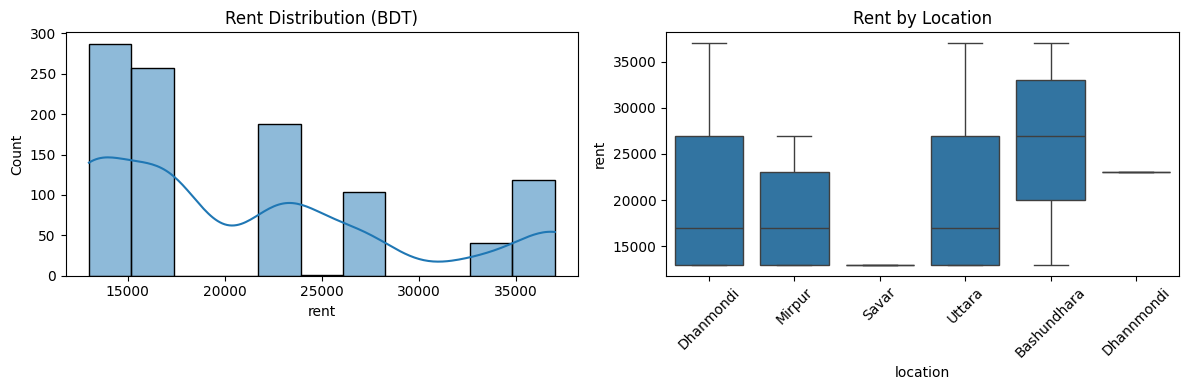

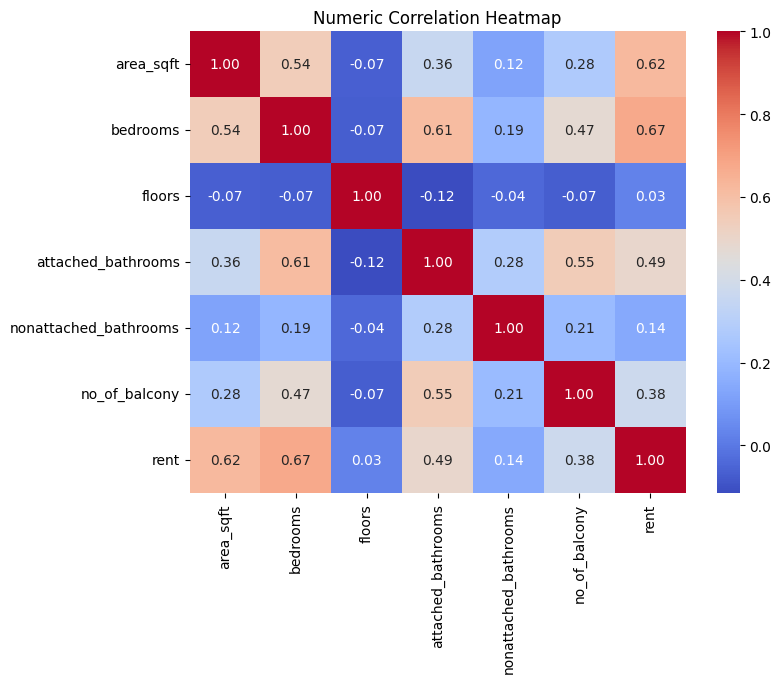


Prepare ML Data

Defining Models

Cross-Validation & Model Comparison
              model       cv_MAE      cv_RMSE     cv_R2
8           XGBoost   811.999841  1841.542480  0.941929
4      RandomForest   717.046320  1873.607867  0.940290
5  GradientBoosting  2157.486372  2937.249634  0.857550
6               KNN  2486.805930  3850.036125  0.756484
2           LassoCV  3739.635851  4827.457847  0.617406
3      ElasticNetCV  3738.884346  4828.969666  0.617121
1           RidgeCV  3738.801805  4829.147002  0.617077
0  LinearRegression  3738.563296  4829.236981  0.617057
7           SVR_rbf  6143.229357  8445.018221 -0.161600

Best base model from CV: XGBoost
Test metrics: {'MAE': 669.4387817382812, 'RMSE': np.float64(1441.0051179645407), 'R2': 0.970483660697937, 'MAPE(%)': np.float64(3.6112510332865813)}
Saved final model pipeline to bd_rent_model.joblib
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://74235d91fff47fef

In [ ]:
# ============================
# DMML Project: BD Rent Prediction
# ============================
# ---- Imports ----
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import gradio as gr
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Regressors
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except:
    HAS_XGB = False

from joblib import dump

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---- Config ----
DATA_PATH = "https://raw.githubusercontent.com/HasanSarkar02/DMML_Project/main/rent_project.csv"
TARGET = "rent"

CATEGORICAL = ["location"]
BINARY = ["tiles", "new_building", "lift_available", "service_rent_incld", "public_transport"]
NUMERIC = ["area_sqft", "bedrooms", "floors", "attached_bathrooms", "nonattached_bathrooms", "no_of_balcony"]

DROP_COLS = []
N_SPLITS = 5

# ---- Utility ----
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_regression(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MAPE(%)": mape(y_true, y_pred)
    }

def print_block(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

# ---- Load & Inspect ----
print_block("Loading Data")

df = pd.read_csv(DATA_PATH)
print(df.head())
print(df.shape)
print(df.dtypes)

# ---- Basic Cleaning & Feature Engineering ----
print_block("Cleaning & Feature Engineering")

for col in CATEGORICAL + BINARY + NUMERIC:
    if col not in df.columns:
        print(f"WARNING: Column {col} not found; creating with NaN")
        df[col] = np.nan

# Convert binary-like columns to lower strings
for col in BINARY:
    df[col] = df[col].astype(str).str.lower()

df[TARGET] = df[TARGET].clip(
    lower=df[TARGET].quantile(0.01),
    upper=df[TARGET].quantile(0.99)
)

df["area_sqft"] = df["area_sqft"].clip(
    lower=df["area_sqft"].quantile(0.01),
    upper=df["area_sqft"].quantile(0.99)
)

print(df.isnull().sum())

# ----  EDA ----
print_block("Quick EDA")

print("Location distribution:")
print(df["location"].value_counts())

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df[TARGET], kde=True, ax=axes[0])
axes[0].set_title("Rent Distribution (BDT)")

sns.boxplot(x="location", y=TARGET, data=df, ax=axes[1])
axes[1].set_title("Rent by Location")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

corr = df[NUMERIC + [TARGET]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Numeric Correlation Heatmap")
plt.show()

# ---- Prepare ML Data ----
print_block("Prepare ML Data")

X = df.drop(columns=[TARGET] + DROP_COLS, errors="ignore")
y = df[TARGET]

cat_cols = [c for c in X.columns if c in CATEGORICAL or c in BINARY]
num_cols = [c for c in X.columns if c in NUMERIC]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# ---- Define Models ----
print_block("Defining Models")

models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-3, 3, 20)),
    "LassoCV": LassoCV(alphas=np.logspace(-3, 2, 30), cv=5, random_state=RANDOM_STATE),
    "ElasticNetCV": ElasticNetCV(alphas=np.logspace(-3, 2, 20), l1_ratio=[.1,.5,.9], cv=5, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
    "KNN": KNeighborsRegressor(n_neighbors=7),
    "SVR_rbf": SVR(kernel="rbf", C=10, epsilon=0.2)
}

if HAS_XGB:
    models["XGBoost"] = XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, tree_method="hist"
    )

# ---- Cross-Validation & Compare ----
print_block("Cross-Validation & Model Comparison")

results = []
scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
    scores = cross_validate(pipe, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append({
        "model": name,
        "cv_MAE": -scores["test_mae"].mean(),
        "cv_RMSE": -scores["test_rmse"].mean(),
        "cv_R2": scores["test_r2"].mean()
    })

cv_df = pd.DataFrame(results).sort_values(by="cv_RMSE")
print(cv_df)

# ---- Train best model ----
best_model_name = cv_df.iloc[0]["model"]
print_block(f"Best base model from CV: {best_model_name}")

best_pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", models[best_model_name])])
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
metrics = evaluate_regression(y_test, y_pred)
print("Test metrics:", metrics)


# ---- Save final pipeline ----
MODEL_PATH = "bd_rent_model.joblib"
dump(best_pipe, MODEL_PATH)
print(f"Saved final model pipeline to {MODEL_PATH}")

#---- User Interface------

MODEL_PATH = "bd_rent_model.joblib"  # Your trained model pipeline


best_pipe = joblib.load(MODEL_PATH)


LOCATION_OPTIONS = ["Mirpur", "Uttara", "Dhanmondi", "Bashundhara", "Savar"]

# Prediction function
def predict_single(location, area_sqft, bedrooms, floors,
                   attached_bathrooms, nonattached_bathrooms,
                   no_of_balcony, tiles, new_building,
                   lift_available, service_rent_incld, public_transport):

    data = pd.DataFrame([{
        "location": location,
        "area_sqft": float(area_sqft),
        "bedrooms": int(bedrooms),
        "floors": int(floors),
        "attached_bathrooms": int(attached_bathrooms),
        "nonattached_bathrooms": int(nonattached_bathrooms),
        "no_of_balcony": int(no_of_balcony),
        "tiles": tiles.lower(),
        "new_building": new_building.lower(),
        "lift_available": lift_available.lower(),
        "service_rent_incld": service_rent_incld.lower(),
        "public_transport": public_transport.lower(),
    }])

    pred = best_pipe.predict(data)[0]
    return f"Predicted Rent (BDT): {round(pred)}"

# UI
with gr.Blocks() as demo:
    gr.Markdown("# 🏠 BD Rent Prediction")

    with gr.Row():
        with gr.Column():
            location = gr.Dropdown(LOCATION_OPTIONS, label="Location", value="Uttara")
            area_sqft = gr.Number(label="Area (sqft)")
            bedrooms = gr.Number(label="Bedrooms")
            floors = gr.Number(label="Floors")
            attached_bathrooms = gr.Number(label="Attached Bathrooms")
            nonattached_bathrooms = gr.Number(label="Non-Attached Bathrooms")
            no_of_balcony = gr.Number(label="Number of Balconies")
            tiles = gr.Radio(["yes", "no"], label="Tiles")
            new_building = gr.Radio(["yes", "no"], label="New Building")
            lift_available = gr.Radio(["yes", "no"], label="Lift Available")
            service_rent_incld = gr.Radio(["yes", "no"], label="Service Rent Included")
            public_transport = gr.Radio(["yes", "no"], label="Near Public Transport")
            predict_btn = gr.Button("Predict")

        with gr.Column():
            output = gr.Textbox(label="Predicted Rent")

    predict_btn.click(
        predict_single,
        inputs=[location, area_sqft, bedrooms, floors, attached_bathrooms,
                nonattached_bathrooms, no_of_balcony, tiles, new_building,
                lift_available, service_rent_incld, public_transport],
        outputs=output
    )

demo.launch(share=True)